# Within Context

The `WithinContext` class is used to extract cells within a given tissue or tissues. Here we will use it to extract all the cancerous tissues and cells within them. The `WithinContext` extracts the cells from the input `cell_gdf` within the areas in the input `area_gdf`.

After fitting the context, The `WithinContext.context` attribute will contain a nested dict where each value is a dict contain the following key-value pairs:

- `roi_area` - the roi areas of type labels (`gpd.GeoDataFrame`)
- `roi_cells` - the cells inside the roi areas. (`gpd.GeoDataFrame`)
- `roi_grid` - the grids fitted on top of the roi areas of type labels. (`gpd.GeoDataFrame`)
- `roi_network` - the network fitted on the roi_cells. (`libpysal.weights.W`)

## The Data

Let's look at the example data we will be using.

In [1]:
from cellseg_gsontools.data import cervix_cells

# sneak peak to the data that will be used in the notebook
cervix_cells().head()

,type,geometry,class_name
uid,,,
1,Feature,"POLYGON ((-10.988 48446.005, -10.988 48453.996...",inflammatory
2,Feature,"POLYGON ((-20.988 48477.996, -19.990 48479.993...",connective
3,Feature,"POLYGON ((-14.988 48767.995, -11.993 48770.990...",inflammatory
4,Feature,"POLYGON ((-3.988 49537.995, -2.995 49538.988, ...",connective
5,Feature,"POLYGON ((-7.988 49562.995, -5.995 49564.988, ...",connective


In [2]:
from cellseg_gsontools.data import cervix_tissue

cervix_tissue().head()

,type,geometry,class_name
uid,,,
1,Feature,"POLYGON ((1852.953 51003.603, 1853.023 51009.1...",areastroma
2,Feature,"POLYGON ((4122.334 48001.899, 4122.994 48014.8...",areagland
3,Feature,"POLYGON ((3075.002 48189.068, 3075.001 48218.8...",areagland
4,Feature,"POLYGON ((51.106 50822.418, 57.151 50834.504, ...",areagland
5,Feature,"POLYGON ((3150.958 52999.764, 3147.245 52996.5...",areastroma


## Fitting the Context

In [3]:
from cellseg_gsontools.spatial_context import WithinContext

# Create a WithinContext object
wcsp = WithinContext(
    area_gdf=cervix_tissue(),
    cell_gdf=cervix_cells(),
    labels="area_cin",  # Extract the cells that are within tissue areas of this type
    min_area_size=50000,  # Discard areas smaller than this
    parallel=False,  # Whether to run in parallel
    num_processes=1,  # Number of processes to use
    graph_type="distband",  # Use a distance band graph (distance thresholded KNN-graph)
    dist_thresh=75,  # Distance threshold for the graph
    backend="geopandas",  # Use geopandas for fitting
    grid_type="hex",  # Use a hexagonal grid
    resolution=10,  # Resolution of the grid
)
wcsp.fit(fit_grid=True, fit_graph=True)

Processing roi area: 3: 100%|██████████| 4/4 [00:00<00:00, 11.62it/s]


In [4]:
# Cells of the first ROI
wcsp.context[0]["roi_cells"].head()

,type,geometry,class_name,global_id
global_id,,,,
9316,Feature,"POLYGON ((7992.01191 49918.00298, 7992.01191 4...",neoplastic,9316
9323,Feature,"POLYGON ((7968.01182 50003.00490, 7968.01191 5...",neoplastic,9323
9329,Feature,"POLYGON ((7910.01182 50037.99510, 7911.00490 5...",neoplastic,9329
9356,Feature,"POLYGON ((7928.01188 50114.00360, 7928.01188 5...",neoplastic,9356
9357,Feature,"POLYGON ((7960.01182 50118.99510, 7962.82642 5...",neoplastic,9357


## Plotting the ROIs

Let's plot the extracted ROIs and cells from the WithinContext class.

<Axes: >

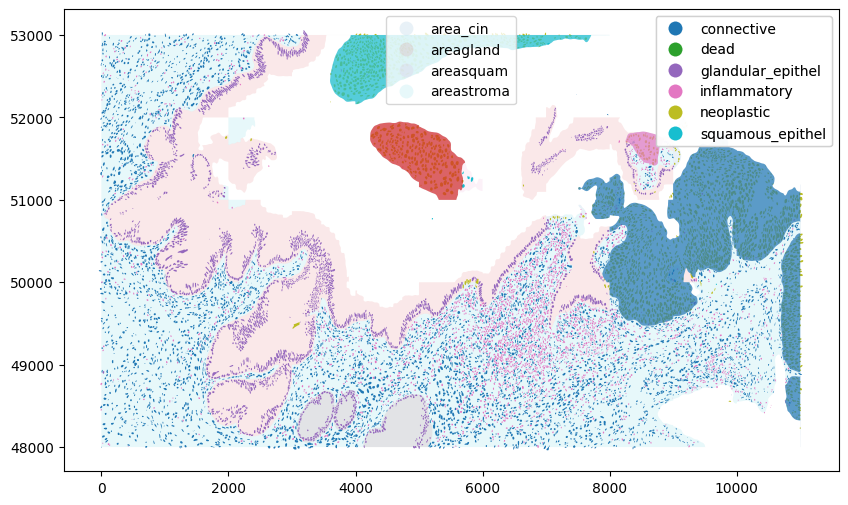

In [5]:
wcsp.plot("roi_area", figsize=(10, 6))

We can also plot the graph and the grid fitted on the cells and the ROIs.

<Axes: >

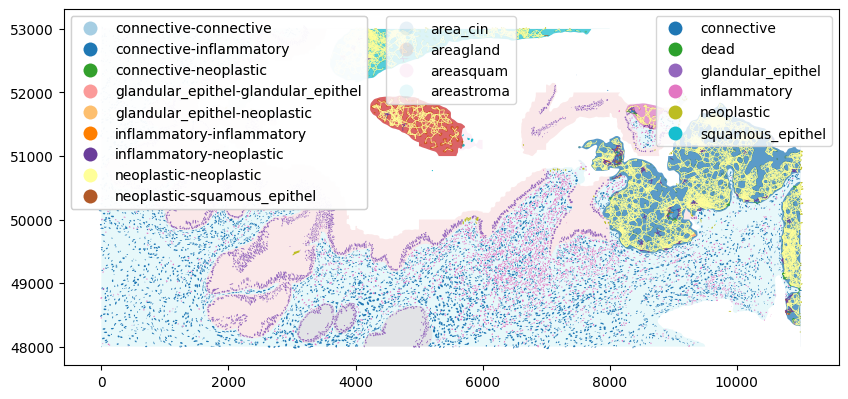

In [6]:
wcsp.plot(
    "roi_area",
    network_key="roi_network",
    figsize=(10, 6),
    edge_kws={"linewidth": 0.5},
)

<Axes: >

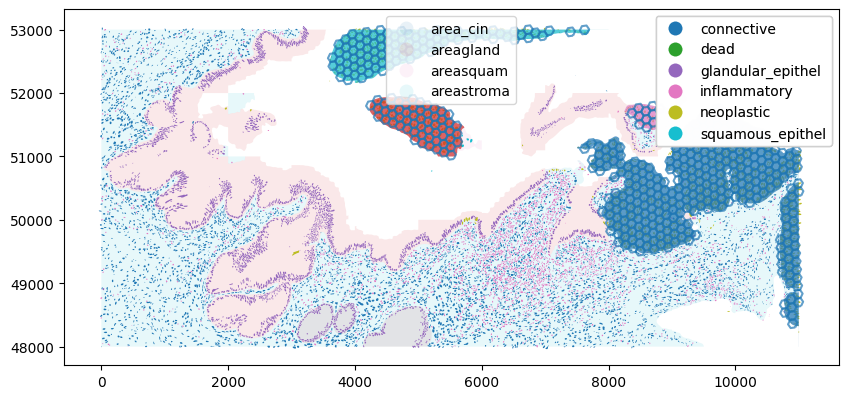

In [7]:
wcsp.plot("roi_area", grid_key="roi_grid", figsize=(10, 6))

##  Downstream Analysis
Now that we've fitted the context, we can use the ROIs in the `context` class attribute to compute more features within the ROIs. Here, we will showcase some lightweight downstream analyses for the extracted ROIs.

### Example 1: Immune Cell Density
Now, if we wanted to compute the density of the inflammatory cells within one of the ROIs, we could use the `roi_grid` key of the context and compute the cell count of the inflammatory cells within the grid cells.

<Axes: >

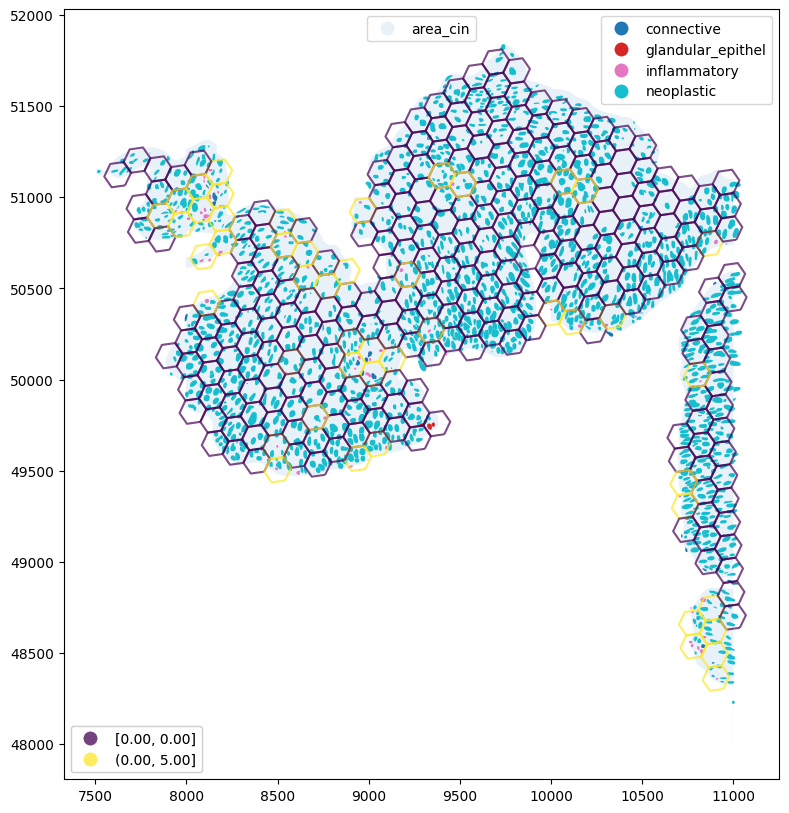

In [8]:
import geopandas as gpd
import mapclassify

from cellseg_gsontools.grid import grid_classify
from cellseg_gsontools.plotting import plot_all


# helper function to replace legend items
def replace_legend_items(legend, mapping):
    for txt in legend.texts:
        for k, v in mapping.items():
            if txt.get_text() == str(k):
                txt.set_text(v)


# Immune cell cnt heuristic to classify the grid cells into two classes
def get_immune_cell_cnt(gdf: gpd.GeoDataFrame, **kwargs) -> int:
    try:
        cnt = gdf.class_name.value_counts()["inflammatory"]
    except KeyError:
        cnt = 0

    return int(cnt)


# Count the immune cells within the grid cells with the cell cnt heuristic
tumor_grid = grid_classify(
    grid=wcsp.context[0]["roi_grid"],
    objs=wcsp.context[0]["roi_cells"],
    metric_func=get_immune_cell_cnt,
    predicate="intersects",
    new_col_names="immune_cnt",
    parallel=False,
)

# bin the grid cells into two classes ("has immune cells" and "no immune cells")
col = "immune_cnt"
bins = mapclassify.Quantiles(tumor_grid[col], k=2)
tumor_grid["immune_density_level"] = bins.yb

immune_density_plot = plot_all(
    wcsp.context[0]["roi_area"],
    wcsp.context[0]["roi_cells"],
    grid_gdf=tumor_grid.copy(),
    figsize=(10, 10),
    grid_col="immune_density_level",
    grid_cmap="viridis",
    grid_n_bins=bins.k,
    show_legends=True,
)
mapping = dict([(i, s) for i, s in enumerate(bins.get_legend_classes())])
replace_legend_items(immune_density_plot.get_legend(), mapping)
immune_density_plot

The plot above pin-points the immune cell hotspots of the ROI.

In [9]:
# The number of grid cells classified to either "has no immune cells" vs "has immune cells"
bins

Quantiles

  Interval     Count
--------------------
[0.00, 0.00] |   267
(0.00, 5.00] |    48

### Example 2: Cell-Cell Interactions

We can also compute the cell-cell interactions between the cells within the ROIs. We can do this by using the `roi_network` key of the context.

In [10]:
from cellseg_gsontools.links import weights2gdf

w = wcsp.context[0]["roi_network"]
w_gdf = weights2gdf(wcsp.context[0]["roi_cells"], w)
w_gdf.head()

,index,focal,neighbor,weight,focal_centroid,neighbor_centroid,focal_class_name,neighbor_class_name,class_name,geometry
0,0,9316,10508,1.0,POINT (8002.844604435322 49918.60883637922),POINT (8071.324684594446 49919.55613239763),neoplastic,neoplastic,neoplastic-neoplastic,"LINESTRING (8002.845 49918.609, 8071.325 49919..."
1,1,9316,10516,1.0,POINT (8002.844604435322 49918.60883637922),POINT (8023.883159119259 49933.338397103355),neoplastic,neoplastic,neoplastic-neoplastic,"LINESTRING (8002.845 49918.609, 8023.883 49933..."
2,2,9316,10528,1.0,POINT (8002.844604435322 49918.60883637922),POINT (8038.75509749847 49978.25936289958),neoplastic,neoplastic,neoplastic-neoplastic,"LINESTRING (8002.845 49918.609, 8038.755 49978..."
3,3,9323,9329,1.0,POINT (7983.698850394024 50017.418546162015),POINT (7917.155129364679 50030.30033051582),neoplastic,neoplastic,neoplastic-neoplastic,"LINESTRING (7983.699 50017.419, 7917.155 50030..."
4,4,9323,9689,1.0,POINT (7983.698850394024 50017.418546162015),POINT (8017.906268884537 50073.52273399252),neoplastic,neoplastic,neoplastic-neoplastic,"LINESTRING (7983.699 50017.419, 8017.906 50073..."


In [11]:
# cell-cell link counts
w_gdf.value_counts("class_name")

class_name
neoplastic-neoplastic                  5601
inflammatory-neoplastic                 322
connective-neoplastic                    73
connective-inflammatory                  47
inflammatory-inflammatory                36
glandular_epithel-neoplastic             14
connective-connective                    10
glandular_epithel-glandular_epithel       3
Name: count, dtype: int64

There are some misclassification of the cell types since some of these cell types should not exist within the tumor area. However, we can see that the cell-cell interactions between the neoplastic cells are the most frequent as expected. The second most frequent connection is between the neoplastic and the immune cells signalling that there are some TILs within the tumor. 

<Axes: >

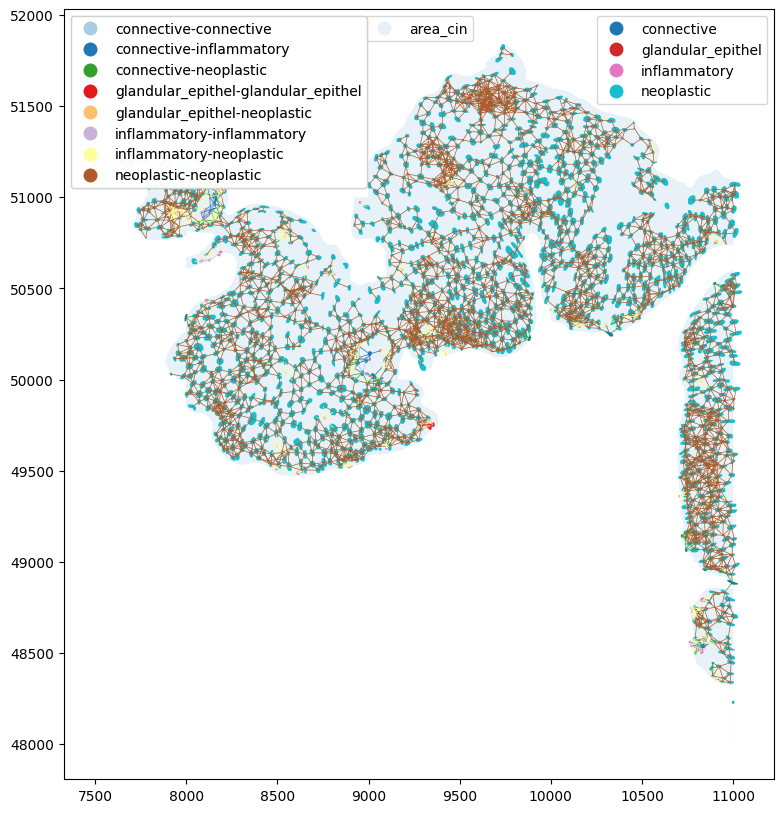

In [12]:
# Let's plot the cell-cell links

plot_all(
    wcsp.context[0]["roi_area"],
    wcsp.context[0]["roi_cells"],
    network_gdf=w_gdf,
    figsize=(10, 10),
    show_legends=True,
    edge_kws={"linewidth": 0.5},
)

### Example 3: Computing Morphological Features of the Tumor Cells

Next, we will compute some basic morphological metrics for the tumor cell shapes.

In [13]:
from cellseg_gsontools.geometry import shape_metric

gdf = wcsp.context[0]["roi_cells"].copy()
tumor_cells = gdf.loc[gdf.class_name == "neoplastic"]  # only neoplastic cells

# morphological metrics to compute
metrics = ["area", "eccentricity", "circularity", "fractal_dimension"]
tumor_cells = shape_metric(
    tumor_cells,
    metrics=metrics,
    parallel=True,
)

tumor_cells[
    ["geometry", "area", "eccentricity", "circularity", "fractal_dimension"]
].head()

,geometry,area,eccentricity,circularity,fractal_dimension
global_id,,,,,
9316,"POLYGON ((7992.01191 49918.00298, 7992.01191 4...",516.835643,0.758648,0.858014,0.758648
9323,"POLYGON ((7968.01182 50003.00490, 7968.01191 5...",715.206484,0.348132,0.849744,0.348132
9329,"POLYGON ((7910.01182 50037.99510, 7911.00490 5...",210.601857,0.469570,0.911534,0.469570
9356,"POLYGON ((7928.01188 50114.00360, 7928.01188 5...",377.421903,0.858783,0.810163,0.858783
9357,"POLYGON ((7960.01182 50118.99510, 7962.82642 5...",1165.683777,0.229062,0.900734,0.229062


In [14]:
# take the mean and std
tumor_cells[metrics].mean(axis=0), tumor_cells[metrics].std(axis=0)

(area                 713.706993
 eccentricity           0.767298
 circularity            0.813745
 fractal_dimension      0.767298
 dtype: float64,
 area                 363.248195
 eccentricity           0.178114
 circularity            0.107053
 fractal_dimension      0.178114
 dtype: float64)

Let's look a little closer at the eccentricity values.

In [15]:
# bin the eccentricity values into 5 classes
col = "eccentricity"

# bin the values with the Fisher-Jenks method
bins = mapclassify.FisherJenks(tumor_cells[col], k=5)
tumor_cells["ecc_level"] = bins.yb
bins

FisherJenks

  Interval     Count
--------------------
[0.00, 0.35] |    74
(0.35, 0.56] |   153
(0.56, 0.72] |   258
(0.72, 0.85] |   529
(0.85, 0.98] |   732

Again, we see that the majority of the cells are in the high eccentricity bins. Let's plot the cells to see the spatial distribution of the high and low eccentricity cells.

In [16]:
# !pip install legendgram

<Axes: >

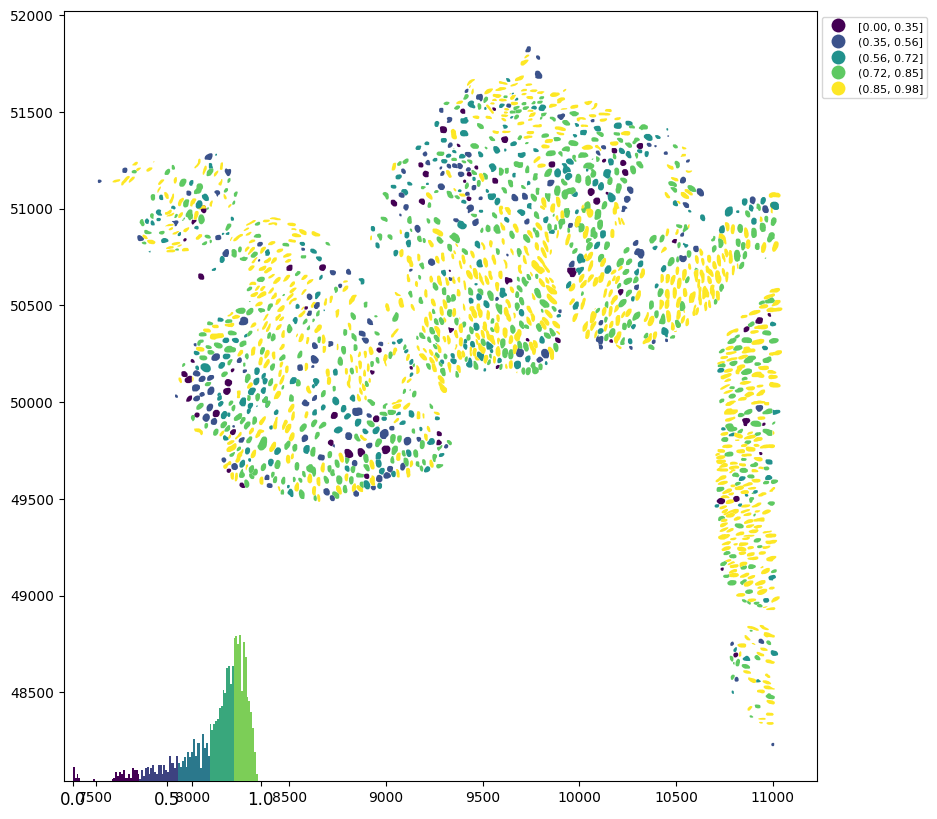

In [17]:
import matplotlib.pyplot as plt
import palettable as palet
from legendgram import legendgram


# Helper function to plot cells with a feature value highlighted
def plot_cells(cells: gpd.GeoDataFrame, col: str):
    # bin the values with the Fisher-Jenks method
    bins = mapclassify.FisherJenks(cells[col], k=5)
    cells["bin_vals"] = bins.yb

    # Let's plot the cells with the eccentricity metric
    f, ax = plt.subplots(figsize=(10, 10))

    ax = cells.plot(
        ax=ax,
        column="bin_vals",
        cmap="viridis",
        categorical=True,
        legend=True,
        legend_kwds={
            "fontsize": 8,
            "loc": "center left",
            "bbox_to_anchor": (1.0, 0.94),
        },
    )

    bin_legends = bins.get_legend_classes()
    mapping = dict([(i, s) for i, s in enumerate(bin_legends)])
    replace_legend_items(ax.get_legend(), mapping)

    ax = legendgram(
        f,
        ax,
        cells[col],
        bins=100,
        breaks=bins.bins,
        pal=palet.matplotlib.Viridis_5,
        loc="lower left",
    )

    return ax


# Let's plot the cells with the eccentricity metric
plot_cells(tumor_cells, col="eccentricity")

We can see that the high eccentricity cells can locate quite randomly in the tumor, although maybe a bit more to the inner border of the tissue. By computing the neighborhood average of the eccentricity values, we could see if the high eccentricity cells tend to locate near each other. This will be done next.

### Example 4: Computing neighborhood statistics

We will compute the neighborhood average of the eccentricity of the tumor cells. This can be done by using the `local_character` function.

In [18]:
from cellseg_gsontools.character import local_character

w = wcsp.context[0]["roi_network"]
cells = wcsp.context[0]["roi_cells"].copy()

# compute first the eccentricity for all the cells in the ROI
metrics = ["eccentricity"]
cells = shape_metric(
    cells,
    metrics=metrics,
    parallel=True,
)

# compute the mean eccentricity of each cell's neighborhood
cells = local_character(
    cells,
    spatial_weights=w,
    val_col="eccentricity",
    id_col="global_id",
    reductions=["mean"],  # mean, median, sum,
    weight_by_area=False,  # weight the values by the object areas
    parallel=True,
    rm_nhood_cols=False,
)

cols = ["geometry", "class_name", "eccentricity", "nhood", "eccentricity_nhood_mean"]
cells[cols].head()

,geometry,class_name,eccentricity,nhood,eccentricity_nhood_mean
global_id,,,,,
9316,"POLYGON ((7992.01191 49918.00298, 7992.01191 4...",neoplastic,0.758648,"[9316, 10508, 10516, 10528]",0.576694
9323,"POLYGON ((7968.01182 50003.00490, 7968.01191 5...",neoplastic,0.348132,"[9323, 9329, 9689, 10528, 10551, 10561]",0.524408
9329,"POLYGON ((7910.01182 50037.99510, 7911.00490 5...",neoplastic,0.469570,"[9329, 9323]",0.408851
9356,"POLYGON ((7928.01188 50114.00360, 7928.01188 5...",neoplastic,0.858783,"[9356, 9357, 9372, 9690]",0.577453
9357,"POLYGON ((7960.01182 50118.99510, 7962.82642 5...",neoplastic,0.229062,"[9357, 9356, 9372, 9689, 9690, 10594, 10601]",0.536294


<Axes: >

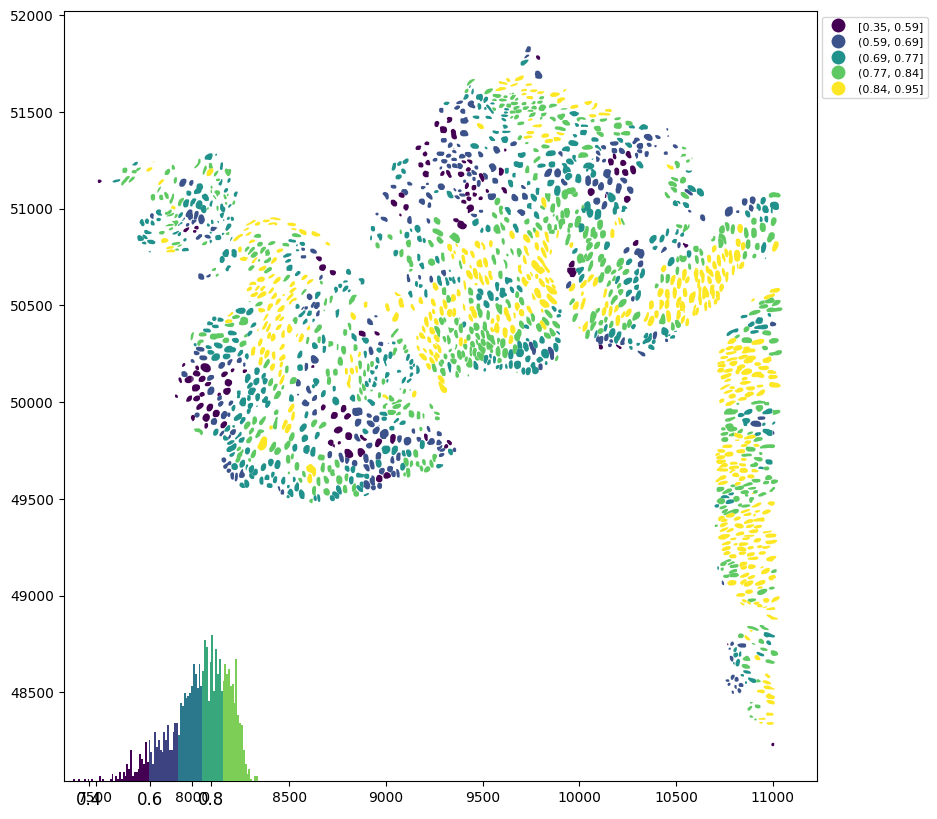

In [19]:
plot_cells(cells, "eccentricity_nhood_mean")

You can see from the plot that the high eccentricity cell neighborhoods locate quite near the the border of the tumor. This is a feature of the cervical tumor where less mature basal epithelial cells are more spindle like and tend to locate at the border of the tissue. 

Next, we’ll compute how diverse the cell neighborhoods are in terms of eccentricity. This can be done by computing the shannon entropy of the eccentricity values of each cell neighborhood. The larger the shannon entropy is, the more diverse the cell neighborhood is in terms of the eccentricity.

In [20]:
from cellseg_gsontools.diversity import local_diversity

# compute the heterogeneity of the neighborhood areas
cells = local_diversity(
    cells,
    spatial_weights=w,
    val_col="eccentricity",
    id_col="global_id",
    metrics=["shannon_index"],
)

cols = cols = ["geometry", "class_name", "eccentricity", "eccentricity_shannon_index"]
cells[cols].head()

,geometry,class_name,eccentricity,eccentricity_shannon_index
global_id,,,,
9316,"POLYGON ((7992.01191 49918.00298, 7992.01191 4...",neoplastic,0.758648,0.693147
9323,"POLYGON ((7968.01182 50003.00490, 7968.01191 5...",neoplastic,0.348132,1.011404
9329,"POLYGON ((7910.01182 50037.99510, 7911.00490 5...",neoplastic,0.469570,0.000000
9356,"POLYGON ((7928.01188 50114.00360, 7928.01188 5...",neoplastic,0.858783,0.693147
9357,"POLYGON ((7960.01182 50118.99510, 7962.82642 5...",neoplastic,0.229062,0.955700


<Axes: >

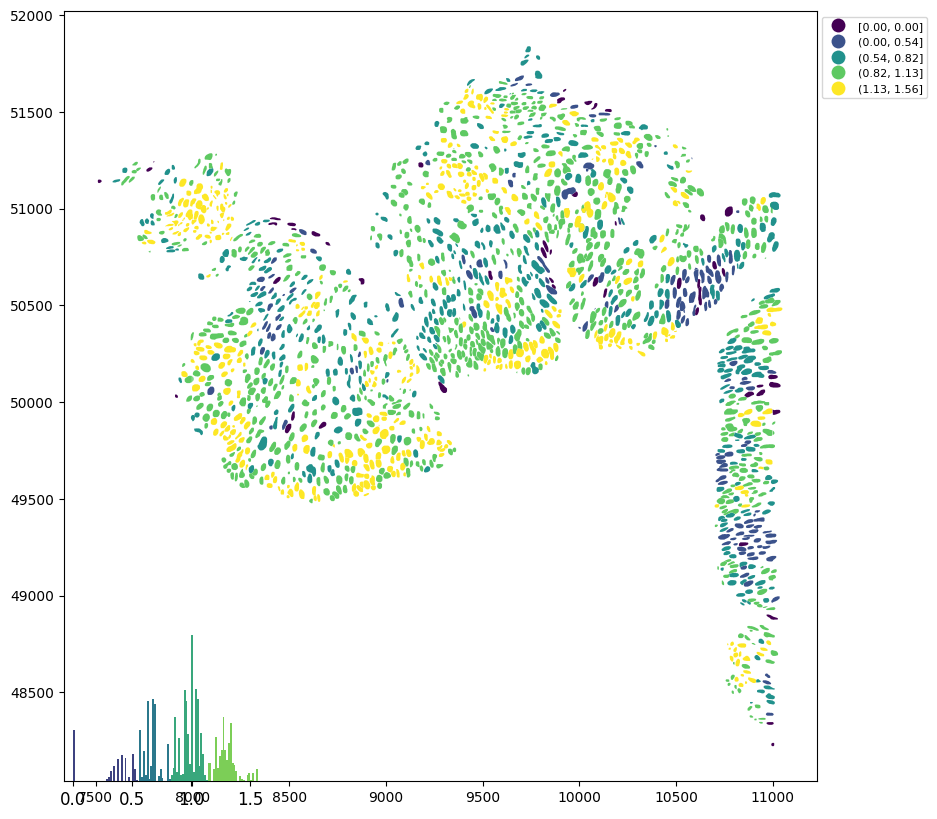

In [21]:
plot_cells(cells, "eccentricity_shannon_index")